# PCA for best subset regression

### Input

In [22]:
import sys
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as plt

# Experiment Data
X = np.loadtxt("../model1_best_subset_regression/data/x.txt", delimiter=",")
n,p = X.shape
Y = np.loadtxt("../model1_best_subset_regression/data/y.txt", delimiter=",")
names = np.loadtxt("../model1_best_subset_regression/data/names.txt", delimiter=",", dtype=str)[0:8]

### EDA

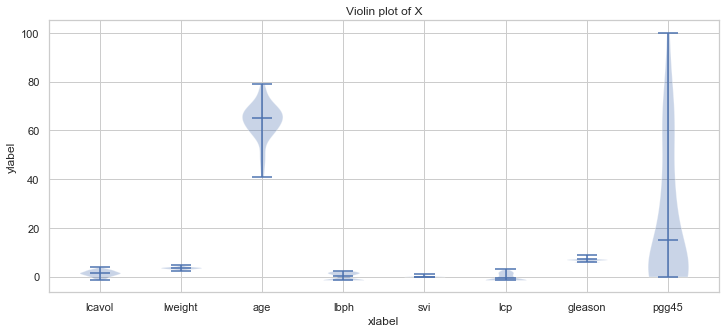

In [23]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.violinplot(X, showmeans=False, showmedians=True)
axes.set_title('Violin plot of X')
axes.yaxis.grid(True)
axes.set_xticks([y + 1 for y in range(p)], )
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')
plt.setp(axes, xticks=[y + 1 for y in range(p)],
         xticklabels=names,)
plt.show()

### Principle component analysis

#### Step 1. Standardization

In [24]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y.reshape(-1, 1))

#### Step 2. Calculate the covariance matrix of the standardized matrix, that is, the correlation coefficient matrix of the original matrix
- Use `np.cov` or `np.corrcoef`
    - The correlation coefficient matrix of the original matrix is the covariance matrix of the normalized matrix
- Using covariance matrix formula for `X.scaled`

In [25]:
n,p = X.shape
X_cor = np.corrcoef(X_scaled.T)
print('Covariance matrix of X_scaled: \n%s' %X_cor)

Covariance matrix of X_scaled: 
[[ 1.          0.28052139  0.22499988  0.0273497   0.538845    0.67531048
   0.43241706  0.43365225]
 [ 0.28052139  1.          0.34796911  0.44226439  0.15538491  0.16453715
   0.0568821   0.10735379]
 [ 0.22499988  0.34796911  1.          0.3501859   0.11765804  0.12766775
   0.2688916   0.27611245]
 [ 0.0273497   0.44226439  0.3501859   1.         -0.08584324 -0.00699943
   0.07782045  0.07846002]
 [ 0.538845    0.15538491  0.11765804 -0.08584324  1.          0.67311118
   0.32041222  0.45764762]
 [ 0.67531048  0.16453715  0.12766775 -0.00699943  0.67311118  1.
   0.51483006  0.63152825]
 [ 0.43241706  0.0568821   0.2688916   0.07782045  0.32041222  0.51483006
   1.          0.75190451]
 [ 0.43365225  0.10735379  0.27611245  0.07846002  0.45764762  0.63152825
   0.75190451  1.        ]]


#### Step 3. Eigen value & vector of the covariance matrix

In [26]:
eig_vals, eig_vecs = np.linalg.eigh(X_cor)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.33648701  0.17349703 -0.62501056  0.40591988  0.10063444  0.33161511
   0.05369897 -0.42224005]
 [-0.05978282 -0.01046653  0.53236051  0.43787933 -0.13182374  0.4224938
  -0.53877313 -0.18712415]
 [-0.08228769 -0.11361112 -0.05859593 -0.14212325  0.79275344 -0.24245431
  -0.46863197 -0.22322795]
 [ 0.03729392  0.08275523 -0.36257286 -0.43575621 -0.51054935 -0.08336125
  -0.62886897 -0.08562866]
 [ 0.04314492  0.46041071  0.28266015 -0.58336083  0.12037404  0.39519323
   0.20742156 -0.39020837]
 [-0.51526685 -0.6321386  -0.12396509 -0.12048346 -0.13602816  0.18687032
   0.19008256 -0.46417852]
 [-0.44086034  0.49109579  0.04920223  0.27860398 -0.15808421 -0.53818216
   0.07198888 -0.40572527]
 [ 0.64290058 -0.31189904  0.30557578 -0.03101518 -0.15934987 -0.4062745
   0.08608338 -0.44406941]]

Eigenvalues 
[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]


#### Test 

In [27]:
# Schmidt orthogonalize
def schmidt_orthogonality(matrix_org, debug=False):
    """
    b1 = a1, b2 = a2 - kb1, b3 = a3 - k1b1 - k2b2
    :param matrix_org: m x n matrix, m >= n 且满秩
    :return:
    """
    m, n = matrix_org.shape
    matrix_ortho = matrix_org.copy()
    matrix_ortho = np.asarray(matrix_ortho, dtype=np.float)
    coefficient = np.zeros(shape=(m, n)) # 系数矩阵k、k1、k2
    coefficient[0, 0] = 1 # b1 = a1

    for i in range(1, n):  # 开始处理下一列
        coefficient[i, i] = 1
        for j in range(i):
            b_j = matrix_ortho[:, j]
            k_j = np.dot(b_j, matrix_org[:, i]) / np.dot(b_j, b_j)
            coefficient[j, i] = k_j
            matrix_ortho[:, i] -= k_j * b_j
	# 正交向量b1,b2...做正交化处理，系数也做相应的改变
    for i in range(n):
        devider = np.dot(matrix_ortho[:, i], matrix_ortho[:, i])
        if abs(devider) < 1e-16:  # 避免除以0
            matrix_ortho[:, i] *= 0
        else:
            devider = np.sqrt(devider)
            matrix_ortho[:, i] /= devider
            coefficient[i, :] *= devider

    return matrix_ortho


In [28]:
# 计算特征向量矩阵经过施密特正交化后的矩阵Q
Q = schmidt_orthogonality(eig_vecs)
# 通过QT.X.Q将矩阵进行对角化
X_cor_diag = Q.T.dot(X_cor).dot(Q)

# 验证：特征值=矩阵被Q对角化的结果
print(eig_vals) # Eigen value
print(X_cor_diag.diagonal()) # Schimite calculated result

[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]
[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]


In [29]:
# test tthe norm of standardlized matrix has norm = 1
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1, np.linalg.norm(ev))
    print("check")

check
check
check
check
check
check
check
check


#### Calculat priciple component

In [38]:
X_pca = np.dot(X_scaled, eig_vecs)

In [31]:
X_cor.dot(eig_vecs[:,1])

array([ 0.04556445, -0.00274876, -0.02983699,  0.0217335 ,  0.12091482,
       -0.16601466,  0.12897346, -0.08191212])

In [32]:
eig_vals[1]*(eig_vecs[:,1])

array([ 0.04556445, -0.00274876, -0.02983699,  0.0217335 ,  0.12091482,
       -0.16601466,  0.12897346, -0.08191212])

In [33]:
eig_pairs = list(zip(eig_vals,eig_vecs))
eig_pairs.sort()
eig_pairs.reverse()
eig_pairs

[(3.3607451984576997,
  array([ 0.64290058, -0.31189904,  0.30557578, -0.03101518, -0.15934987,
         -0.4062745 ,  0.08608338, -0.44406941])),
 (1.6483063120117716,
  array([-0.44086034,  0.49109579,  0.04920223,  0.27860398, -0.15808421,
         -0.53818216,  0.07198888, -0.40572527])),
 (0.975661040905152,
  array([-0.51526685, -0.6321386 , -0.12396509, -0.12048346, -0.13602816,
          0.18687032,  0.19008256, -0.46417852])),
 (0.6320110958860928,
  array([ 0.04314492,  0.46041071,  0.28266015, -0.58336083,  0.12037404,
          0.39519323,  0.20742156, -0.39020837])),
 (0.4832908926534464,
  array([ 0.03729392,  0.08275523, -0.36257286, -0.43575621, -0.51054935,
         -0.08336125, -0.62886897, -0.08562866])),
 (0.4422130128299306,
  array([-0.08228769, -0.11361112, -0.05859593, -0.14212325,  0.79275344,
         -0.24245431, -0.46863197, -0.22322795])),
 (0.26262382548550783,
  array([-0.05978282, -0.01046653,  0.53236051,  0.43787933, -0.13182374,
          0.4224938 , 

##### Determine the principle components that stay.

In [34]:
# Total
tot = sum(eig_vals)
# Cumulative ratio
var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

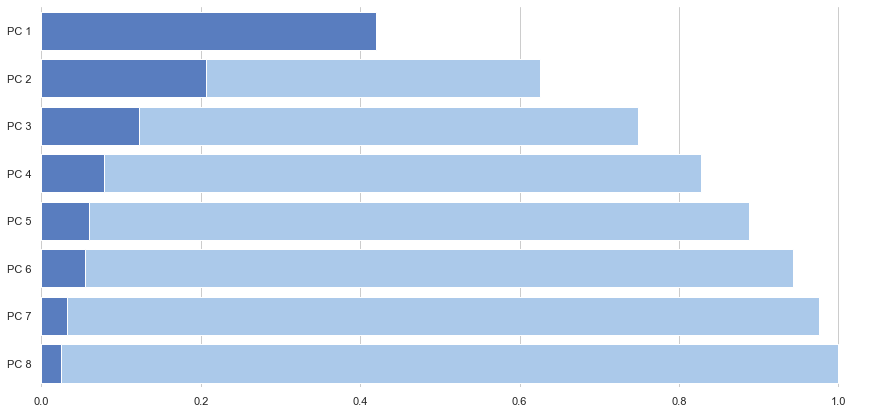

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

PC_indexes = ['PC %s' %(i+1) for i in range(p)]
f, ax = plt.subplots(figsize=(15, 7))
sns.set_color_codes("pastel")
sns.barplot(y=PC_indexes, x=cum_var_exp,color="b")
sns.set_color_codes("muted")
sns.barplot(y=PC_indexes, x=var_exp,color="b")
sns.despine(left=True, bottom=True)
plt.show()

- From this plot, 3/4 components can give us about 80% varicance explained

In [36]:
# Use 3
PCA_X_scaled_manual = np.array([X_scaled.dot(eig_pairs[i][1]) for i in range(3)]).T

# Use all and then do best subset regression!
PCA_X_scaled = np.array([X_scaled.dot(eig_pairs[i][1]) for i in range(p)]).T

#### Use full subset regression using principal components

In [37]:
sys.path.append("..")
from model1_best_subset_regression import BestSubsetReg as BSR
reg1 = BSR.BestSubsetReg(PCA_X_scaled, Y_scaled,names = PC_indexes,inter=False,isCV=False)
reg1.results()

—————Based on Cp ———————
['PC 1' 'PC 2' 'PC 3' 'PC 4' 'PC 5' 'PC 6' 'PC 7' 'PC 8']
[ True  True  True False False False  True  True]
             β
PC 1  0.182352
PC 2 -0.176886
PC 3 -0.567179
PC 7 -0.140569
PC 8  0.303308
—————————————————————————
Cp  = 0.38716596894837435
—————————————————————————

—————Based on AIC ———————
['PC 1' 'PC 2' 'PC 3' 'PC 4' 'PC 5' 'PC 6' 'PC 7' 'PC 8']
[ True  True  True False False False  True  True]
             β
PC 1  0.182352
PC 2 -0.176886
PC 3 -0.567179
PC 7 -0.140569
PC 8  0.303308
—————————————————————————
AIC  = 351.7324012963414
—————————————————————————

